## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy


In [0]:
# import libraries
from scipy.stats import ttest_ind, ttest_1samp, ttest_rel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### CONFIDENCE INTERVALS

In [5]:
# get data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data

--2020-02-04 17:30:49--  https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18171 (18K) [application/x-httpd-php]
Saving to: ‘house-votes-84.data.1’

house-votes-84.data 100%[===================>]  17.75K  --.-KB/s    in 0.06s   

2020-02-04 17:30:50 (286 KB/s) - ‘house-votes-84.data.1’ saved [18171/18171]



In [6]:
# read in the data
votes = pd.read_csv('house-votes-84.data.1')

# check 
votes.head()

,republican,n,y,n.1,y.1,y.2,y.3,n.2,n.3,n.4,y.4,?,y.5,y.6,y.7,n.5,y.8
0,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
1,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
2,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
3,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y
4,democrat,n,y,y,n,y,y,n,n,n,n,n,n,y,y,y,y


In [7]:
# add column headers
column_headers = ['party','handicapped-infants','water-project',
                          'budget','physician-fee-freeze', 'el-salvador-aid',
                          'religious-groups','anti-satellite-ban',
                          'aid-to-contras','mx-missile','immigration',
                          'synfuels', 'education', 'right-to-sue','crime',
                          'duty-free',
                          'south-africa']

# re read in the data frame
votes = votes = pd.read_csv('house-votes-84.data',
                            header=None, 
                            names=column_headers, 
                            na_values="?")

# check
votes.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,NaN,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,NaN
2,democrat,NaN,y,y,NaN,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,NaN,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,NaN,y,y,y,y


In [8]:
# replace notes as numeric 
votes = votes.replace({'y':1, 'n':0})

# check
votes.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


In [9]:
# filter by party
# republicans 
rep = votes[votes['party']=='republican']

#see
rep.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
7,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,1.0
8,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
10,republican,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,1.0,0.0,0.0


In [10]:
# how the democrats voted
dem = votes[votes['party']=='democrat']

# see 
dem.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0
5,democrat,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
6,democrat,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,1.0,1.0


In [0]:
# calculating the confidence interval for likelihood that a republican
# will vote in favor of the south-africa issue

In [13]:
# what is the average support among dem
dem_SA = dem['south-africa'] 
dem_SA.head()

2    0.0
3    1.0
4    1.0
5    1.0
6    1.0
Name: south-africa, dtype: float64

In [0]:
# calculate the standard deviation
dem_std = dem['south-africa'].std()

In [15]:
# number of values in the sample
n = len(dem['south-africa'])
n

267

In [0]:
# import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# calculate the confidence interval
def confidence_interval(data, confidence=0.95):
  data = dem_SA
  mean = np.mean(data)
  n = len(dem['south-africa'])
  stderr = np.std(data, ddof=1)/np.sqrt(n)
  moe = stderr * stats.t.ppf((1 + confidence)/2.0, n-1)
  return(mean -moe, mean + moe)

In [23]:
# confidence interval
confidence_interval(dem_SA)

(0.9053779496998557, 0.9648923205704145)

### Using a graph

In [37]:
# Not sure what i'm doing wrong here. 

# calculated confidence interval
conf_int = stats.t.interval(0.95, 
                            len(dem['south-africa']), 
                            loc = np.mean(dem_SA), 
                            scale = stats.sem(dem['south-africa']) 
                            )

conf_int

(nan, nan)

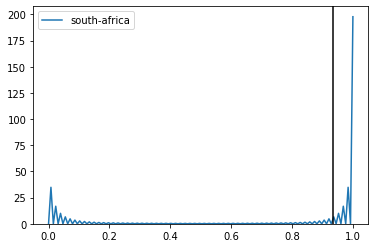

In [38]:
# plot on a graph
sns.kdeplot(dem['south-africa'])
plt.axvline(x=conf_int[0], color='red')
plt.axvline(x=conf_int[1], color='red')
plt.axvline(x=dem['south-africa'].mean(), color='k');

### Chi-Squared tests

In [40]:
# read in data
df = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/adult.csv', na_values=" ?")

#check
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [42]:
# desccribe
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [43]:
# decribe the non-numeric columns (categorical)
df.describe(exclude='number')

,workclass,education,marital-status,occupation,relationship,race,sex,country,salary
count,30725,32561,32561,30718,32561,32561,32561,31978,32561
unique,8,16,7,14,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


In [46]:
# create some binned categories
cut_points = [0, 9, 19, 29, 39, 49, 1000]
label_names = ['0-9', '10-19', '20-29', '20-39', '40-49', '50+']
df['hours_per_week_categories'] = pd.cut(df['hours-per-week'], cut_points, labels=label_names)

#check for new category
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary,hours_per_week_categories
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,40-49
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,10-19
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,40-49
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,40-49
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,40-49


In [47]:
# check for sex distribution
df['sex'].value_counts()

 Male      21790
 Female    10771
Name: sex, dtype: int64

In [51]:
# check the number of people working specific categories of hours
# based on newly created category
df['hours_per_week_categories'].value_counts()

40-49    18336
50+       6462
20-39     3667
20-29     2392
10-19     1246
0-9        458
Name: hours_per_week_categories, dtype: int64

In [52]:
# create a new df sorted according to hours worked pre week, ascending order
df = df.sort_values(by='hours_per_week_categories', ascending=True)

# check
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary,hours_per_week_categories
31290,55,Self-emp-not-inc,41938,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,0,8,United-States,<=50K,0-9
5172,32,NaN,134886,HS-grad,9,Married-civ-spouse,NaN,Wife,White,Female,0,0,2,United-States,>50K,0-9
22928,17,NaN,332666,10th,6,Never-married,NaN,Own-child,White,Female,0,0,4,United-States,<=50K,0-9
7902,35,Private,359131,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,White,Female,7298,0,8,NaN,>50K,0-9
6604,41,Private,406603,HS-grad,9,Never-married,Other-service,Not-in-family,White,Male,0,0,6,Iran,<=50K,0-9


In [53]:
# create a new table. compares sex with hours worked per week categories
contigency_table = pd.crosstab(df['sex'], df['hours_per_week_categories'], margins=True)

# check 
contigency_table

hours_per_week_categories,0-9,10-19,20-29,20-39,40-49,50+,All
sex,,,,,,,
Female,235,671,1287,1914,5636,1028,10771
Male,223,575,1105,1753,12700,5434,21790
All,458,1246,2392,3667,18336,6462,32561


In [54]:
# create a set of female counts
femalecount = contigency_table.iloc[0][0:6].values

# check
femalecount

array([ 235,  671, 1287, 1914, 5636, 1028])

In [2]:
# calculate chi squared
import numpy as np
chisquare(femalecount)

NameError: ignored

## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)